In [1]:
import sys
sys.path.append('../source/')
sys.path.append('../utilities/')
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import numpy as np
import bm
import utilities
from scipy.linalg import eigh
import matplotlib.pyplot as plt
%matplotlib inline

/specific/netapp5_2/iscb/wolfson/jeromet/v_env/p36_tf/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 7000. The TBB threading layer is disabled.
  warnings.warn(problem)
../source/numba_utilities.py:1109: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
../source/numba_utilities.py:1110: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dvar_e_dw = np.dot(s2.T, V)
../source/numba_utilities.py:1111: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  tmp3 = np.dot(s3.T, V)
../source/numba_utilities.py:946: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (arra

# Generate data from a discrete XY model
- We use discrete angles $\frac{2\pi c}{n_c}$, $c \in [0, n_c-1]$.
- Energy function takes form E = - $\sum_i \cos (\theta_i - \theta_{i+1})$
- Data is generated with a Potts model.
- Show descriptive statistics: Top eigenvector, correlation matrix.


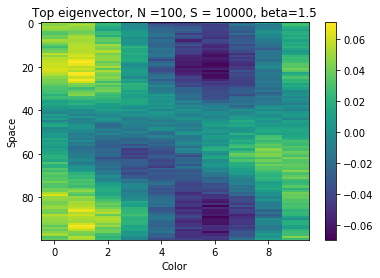

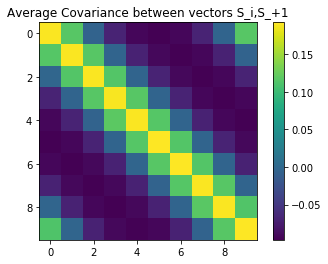

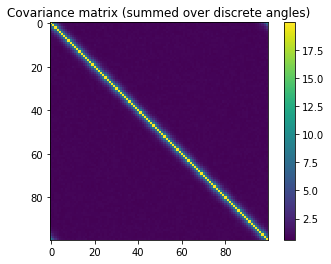

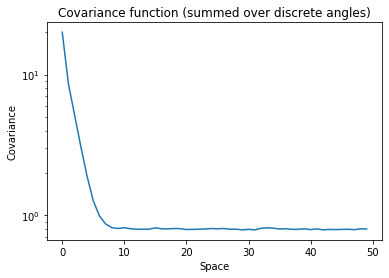

In [2]:
N = 100
beta = 1.5
n_c = 10
thetas = 2*np.pi/n_c * np.arange(n_c)
costhetas = np.cos(thetas[np.newaxis]-thetas[:,np.newaxis])

BM = bm.BM(N=N,n_c=n_c,nature='Potts')
J = np.zeros([N,N,n_c,n_c])
for n in range(N-1):
    J[n,n+1,:,:] = beta * costhetas
    J[n+1,n,:,:] = beta * costhetas.T
J[N-1,0,:,:] = beta * costhetas
J[0,N-1,:,:] = beta * costhetas.T

BM.layer.couplings = J.astype(np.float32)


data = BM.gen_data(Nchains=100,Lchains=100,Nthermalize=1000,Nstep=100) # Need to set Lchains = 1e4, Nstep = 300 to be exactly translational invariant
C = utilities.covariance(data,data,c1=n_c,c2=n_c)
diag = C[np.arange(N),np.arange(N),:,:][:,np.arange(n_c),np.arange(n_c)]
C/= np.sqrt(diag[:,np.newaxis,:,np.newaxis] * diag[np.newaxis,:,np.newaxis,:])

C2D = np.swapaxes(C,1,2).reshape([n_c*N,n_c*N]) # Does the same thing as the commented code below.

# C2D = np.zeros([N*n_c,N*n_c])
# for i1 in range(N):
#     for i2 in range(N):
#         for c1 in range(n_c):
#             for c2 in range(n_c):
#                 C2D[i1*n_c+c1,i2*n_c+c2] = C[i1,i2,c1,c2]
 

lam,V = eigh(C2D);
idx = np.argmax(lam)

top_eigenvector = V[:,idx].reshape([N,n_c]);
plt.imshow(top_eigenvector,aspect='auto'); plt.colorbar();
plt.xlabel('Color');
plt.ylabel('Space');
plt.title('Top eigenvector, N =%s, S = %s, beta=%s'%(N,data.shape[0],beta));
plt.savefig('XY_Top_eigenvector_N%s_S%s_beta%s.png'%(N,data.shape[0],beta));
plt.show()


neighbor_C = np.zeros([n_c,n_c])
for n in range(N):
    if n == N-1:
        i = n
        j = 0
    else:
        i = n
        j = n+1
    neighbor_C += C[i,j]
neighbor_C /= N
plt.imshow(neighbor_C)
plt.colorbar()
plt.title('Average Covariance between vectors S_i,S_+1')
plt.savefig('XY_neighbor_covariance_N%s_S%s_beta%s.png'%(N,data.shape[0],beta));
plt.show()


correlation = np.abs(C).sum(-1).sum(-1)
plt.imshow(correlation); plt.colorbar()
plt.title('Covariance matrix (summed over discrete angles)')
plt.savefig('XY_covariance_summed_N%s_S%s_beta%s.png'%(N,data.shape[0],beta));
plt.show()

delta_C = np.zeros(N//2)
for k in range(N//2):
    index1 = np.arange(N)
    index2 = (np.arange(N) + k) % N
    delta_C[k] = np.abs(correlation)[index1,index2].mean()
plt.semilogy(delta_C)
plt.xlabel('Space')
plt.ylabel('Covariance')
plt.title('Covariance function (summed over discrete angles)')
plt.savefig('XY_covariance_function_N%s_S%s_beta%s.png'%(N,data.shape[0],beta));
plt.show()



In [3]:
C = utilities.covariance(data,data,c1=n_c,c2=n_c)
diag = C[np.arange(N),np.arange(N),:,:][:,np.arange(n_c),np.arange(n_c)]
C/= np.sqrt(diag[:,np.newaxis,:,np.newaxis] * diag[np.newaxis,:,np.newaxis,:])
C2D = np.swapaxes(C,1,2).reshape([n_c*N,n_c*N]) # Does the same thing as the commented code below.



order = np.argsort(np.random.randn(data.shape[0],N),axis=0)
shuffled_data = np.zeros_like(data)
for n in range(N):
    shuffled_data[:,n] = data[order[:,n],n]
C_shuffled = utilities.covariance(shuffled_data,shuffled_data,c1=n_c,c2=n_c)
diag_shuffled = C_shuffled[np.arange(N),np.arange(N),:,:][:,np.arange(n_c),np.arange(n_c)]
C_shuffled /= np.sqrt(diag_shuffled[:,np.newaxis,:,np.newaxis] * diag_shuffled[np.newaxis,:,np.newaxis,:])

C2D_shuffled = np.swapaxes(C_shuffled,1,2).reshape([n_c*N,n_c*N]) # Does the same thing as the commented code below.

# C2D = np.zeros([N*n_c,N*n_c])
# for i1 in range(N):
#     for i2 in range(N):
#         for c1 in range(n_c):
#             for c2 in range(n_c):
#                 C2D[i1*n_c+c1,i2*n_c+c2] = C[i1,i2,c1,c2]
 

lam,V = eigh(C2D);
idx = np.argmax(lam)
print(lam[idx])

lam_shuffled,V_shuffled = eigh(C2D_shuffled);
idx_shuffled = np.argmax(lam_shuffled)
print(lam_shuffled[idx_shuffled])



    
    

4.6165085
1.855394


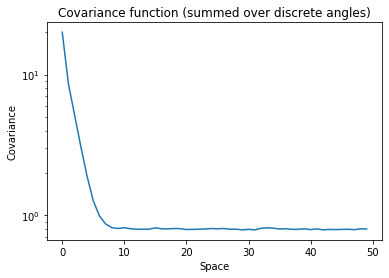

In [4]:
delta_C = np.zeros(N//2)
for k in range(N//2):
    index1 = np.arange(N)
    index2 = (np.arange(N) + k) % N
    delta_C[k] = np.abs(correlation)[index1,index2].mean()
plt.semilogy(delta_C)
plt.xlabel('Space')
plt.ylabel('Covariance')
plt.title('Covariance function (summed over discrete angles)')
plt.savefig('XY_covariance_function_N%s_S%s_beta%s.png'%(N,data.shape[0],beta));
plt.show()